# Import Libraries

In [1]:
# %pip install -r requirements.txt
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import pickle
from cv2 import cv2
from skimage import feature
from sklearn import neighbors

# Retrieve Dataset

In [10]:
from preprocess import retrieve_dataset, preprocess, to_np, count_class

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 100,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 25,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

Class breakdown for train dataset:
[(0, 12), (1, 11), (2, 10), (3, 12), (4, 11), (5, 11), (6, 11), (7, 7), (8, 0)]
Class breakdown for test dataset:
[(0, 3), (1, 3), (2, 2), (3, 3), (4, 6), (5, 1), (6, 3), (7, 2), (8, 0)]


# Extract X_train, Y_train, X_test, Y_test

In [11]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [12]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 100
Length of X_test: 25


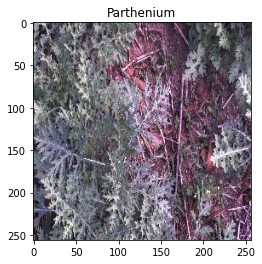

In [13]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [14]:
# Reference: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

## Flatten To Feed into Different Algorithms

In [16]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(100,)
feature size now: (256, 256, 3)


# Test SVM Model with K-Fold Validation

In [17]:
from run_algo_with_kfold import kfold_cross_validation

kernels = ['linear', 'rbf', 'poly', 'sigmoid']

k = 5
accuracies = [kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': kernel}) for kernel in kernels]

Running 5-fold cross validation for svm with {'kernel': 'linear'}
Split accuracy: 0.35
Split accuracy: 0.35
Split accuracy: 0.45
Split accuracy: 0.35
Split accuracy: 0.25
Completed 5-fold cross validation for svm with {'kernel': 'linear'}
Obtained average accuracy of: 0.35

Running 5-fold cross validation for svm with {'kernel': 'rbf'}
Split accuracy: 0.05
Split accuracy: 0.05
Split accuracy: 0.05
Split accuracy: 0.1
Split accuracy: 0.15
Completed 5-fold cross validation for svm with {'kernel': 'rbf'}
Obtained average accuracy of: 0.08

Running 5-fold cross validation for svm with {'kernel': 'poly'}
Split accuracy: 0.05
Split accuracy: 0.05
Split accuracy: 0.05
Split accuracy: 0.1
Split accuracy: 0.15
Completed 5-fold cross validation for svm with {'kernel': 'poly'}
Obtained average accuracy of: 0.08

Running 5-fold cross validation for svm with {'kernel': 'sigmoid'}
Split accuracy: 0.05
Split accuracy: 0.05
Split accuracy: 0.05
Split accuracy: 0.1
Split accuracy: 0.15
Completed 5-fold

In [ ]:
highest_index = np.argmax(accuracies)
best_kernel = kernels[highest_index]

print(f'Best kernel: {best_kernel}')

In [ ]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import get_precision_scores, get_roc_auc_curve, visualize_roc_auc_curve, train_model

In [ ]:
model = train_model('svm', {'kernel': best_kernel}, X_train_flatten, y_train)

{'accuracy': 0.6, 'macro_avg': 0.5662578162578162, 'f1_score_macro': 0.5617497585447511, 'micro_avg': 0.6, 'f1_score_micro': 0.6, 'roc_auc_score': 0.8539503977130953}
{'accuracy': 0.10666666666666667, 'macro_avg': 0.10666666666666667, 'f1_score_macro': 0.1927710843373494, 'micro_avg': 0.10666666666666667, 'f1_score_micro': 0.1927710843373494, 'roc_auc_score': 0.7411855729569247}
{'accuracy': 0.10666666666666667, 'macro_avg': 0.10666666666666667, 'f1_score_macro': 0.1927710843373494, 'micro_avg': 0.10666666666666667, 'f1_score_micro': 0.1927710843373494, 'roc_auc_score': 0.7483961941585402}
{'accuracy': 0.10666666666666667, 'macro_avg': 0.10666666666666667, 'f1_score_macro': 0.1927710843373494, 'micro_avg': 0.10666666666666667, 'f1_score_micro': 0.1927710843373494, 'roc_auc_score': 0.7416586114391949}


In [ ]:
print(get_precision_scores(model, X_test_flatten, y_test))

In [ ]:
(fpr, tpr, roc_auc) = get_roc_auc_curve(model, X_train_flatten, y_train, X_test_flatten, y_test, {'is_svm': False})

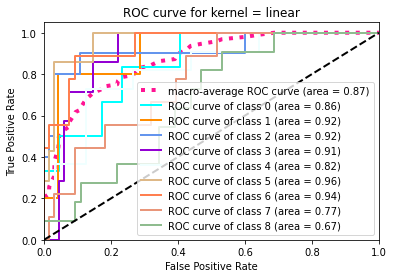

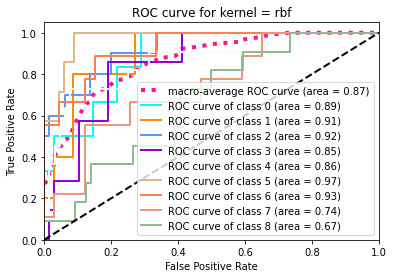

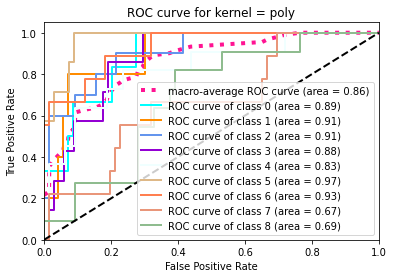

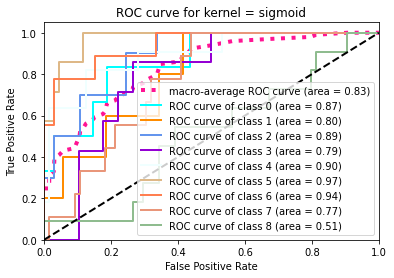

In [ ]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import visualize_roc_auc_curve

title = f'ROC curve for kernel = {str(best_kernel)}'
visualize_roc_auc_curve(title, fpr, tpr, roc_auc, len(np.unique(y_test)))

In [ ]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.001, 0.002, 0.004, 0.008, 0.016]
k = 5

tuning_C_accuracies = [kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C}) for C in Cs]

## Old Results (Previously, we removed the negative class)

In [17]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.125, 0.5, 2, 8, 32]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C, 'gamma': 'scale'})
  final_accuracies.append(final_accuracy)
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C, 'gamma': 'auto'})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'scale'}
Obtained split accuracy of: 0.7685393258426966
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7683658170914542
Obtained split accuracy of: 0.7616191904047976
Obtained split accuracy of: 0.7548725637181409
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'scale'}
Obtained average accuracy of: 0.7594434243552382
Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'auto'}
Obtained split accuracy of: 0.7685393258426966
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7683658170914542
Obtained split accuracy of: 0.7616191904047976
Obtained split accuracy of: 0.7548725637181409
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'auto'}
Obtained average accuracy of: 0.7594434243552382
Running 5-fold cross validation for svm with {

In [ ]:
print(final_accuracies)

In [9]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.023, 0.024, 0.025, 0.026, 0.027]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.023}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.023}
Obtained average accuracy of: 0.7592933870143581

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.024}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.024}
Obtained average accuracy of: 0.7592933870143581

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.025}
Obtained split accuracy of: 0.769288

KeyboardInterrupt: 

In [ ]:
print(final_accuracies)

[]


In [10]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.01, 0.04, 0.16, 0.64]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.01}
Obtained split accuracy of: 0.7685393258426966
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.760119940029985
Obtained split accuracy of: 0.7473763118440779
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.01}
Obtained average accuracy of: 0.7592934993177568

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.04}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.04}
Obtained average accuracy of: 0.7592933870143581

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.16}
Obtained split accuracy of: 0.769288389513

In [11]:
print(final_accuracies)

[0.7592934993177568, 0.7592933870143581, 0.7592933870143581, 0.7592933870143581]


In [13]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.005, 0.015]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)
print(final_accuracies)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.005}
Obtained split accuracy of: 0.7752808988764045
Obtained split accuracy of: 0.748314606741573
Obtained split accuracy of: 0.7811094452773614
Obtained split accuracy of: 0.7698650674662668
Obtained split accuracy of: 0.7443778110944528
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.005}
Obtained average accuracy of: 0.7637895658912118

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.015}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7773613193403298
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.015}
Obtained average accuracy of: 0.7594433120518392

[0.7637895658912118, 0.7594433120518392]


In [14]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.00125, 0.0025, 0.013, 0.017, 0.02]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)
print(final_accuracies)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.00125}
Obtained split accuracy of: 0.7737827715355805
Obtained split accuracy of: 0.7415730337078652
Obtained split accuracy of: 0.7593703148425787
Obtained split accuracy of: 0.7616191904047976
Obtained split accuracy of: 0.7473763118440779
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.00125}
Obtained average accuracy of: 0.75674432446698

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.0025}
Obtained split accuracy of: 0.7797752808988764
Obtained split accuracy of: 0.749812734082397
Obtained split accuracy of: 0.7706146926536732
Obtained split accuracy of: 0.7668665667166417
Obtained split accuracy of: 0.7421289355322339
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.0025}
Obtained average accuracy of: 0.7618396419767646

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.013}
Obtained split accuracy of: 0.767

In [15]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.003, 0.004, 0.006, 0.007, 0.008]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)
print(final_accuracies)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.003}
Obtained split accuracy of: 0.7782771535580524
Obtained split accuracy of: 0.752059925093633
Obtained split accuracy of: 0.7773613193403298
Obtained split accuracy of: 0.7646176911544228
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.003}
Obtained average accuracy of: 0.7636386301231407

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.004}
Obtained split accuracy of: 0.7760299625468164
Obtained split accuracy of: 0.7445692883895131
Obtained split accuracy of: 0.7743628185907047
Obtained split accuracy of: 0.7683658170914542
Obtained split accuracy of: 0.7428785607196402
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.004}
Obtained average accuracy of: 0.7612412894676257

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.006}
Obtained split accuracy of: 0.7752808